## Imports

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from pathlib import Path
import logging

## Variables

In [40]:
cutoff = -0.2

ORGANISMS = ["human", "mouse"]
MIRNAS = ["mir197", "mir769"]
PROJECTDIR = Path('.').resolve().parents[2]

## Paths

In [41]:
targetpath = f'{PROJECTDIR}/milestones/data/targetscan/unweighted_TargetScanHuman_human_mouse_mir197_mir769.tsv'
outdir = f'{PROJECTDIR}/milestones/figures/target_prediction'
differential_genes_path = '{}/milestones/data/rnaseq/{}_{}_differential_genes.tsv'
rnaseq_path = '{}/external_data/counts_matrix/{}_counts.matrix'


## Load data

In [42]:
tardf = pd.read_csv(targetpath, sep='\t')


## Context++-score distribution

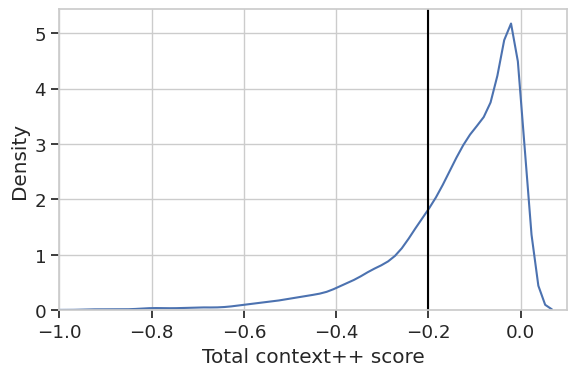

In [43]:
def plot_score_distribution(df, cutoff):
    sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')
    fig = sns.kdeplot(df, x='Total context++ score')
    plt.axvline(cutoff, color='black')
    return fig


fig = plot_score_distribution(tardf, cutoff)
plt.xlim([-1, 0.1])
plt.tight_layout()
plt.savefig(f'{outdir}/context_score_dist.png', dpi=600)
plt.show()

## Count number of predicted targets in each condition (those meeting the threshold criterium)

In [44]:
def count_targets(df, organism, mirna, cutoff):
    df = df[df['Total context++ score'] <= cutoff]
    fdf = df[(df['organism'] == organism) & (df['mirna'] == mirna)]
    print(organism, mirna, fdf.index.size)
    return list(fdf.target_gene.values)
        
print('Number of genes that are predicted as targets:')
condition2target_genes = {}
for organism in ORGANISMS:
    for mirna in MIRNAS:
        condition2target_genes[f'{organism}|{mirna}'] = count_targets(tardf, organism, mirna, cutoff)
print(condition2target_genes)

Number of genes that are predicted as targets:
human mir197 1079
human mir769 935
mouse mir197 792
mouse mir769 839
{'human|mir197': ['CDH17', 'KCNQ1', 'MT3', 'ST13', 'OXT', 'SLC32A1', 'PGRMC1', 'CBLN1', 'KIAA1199', 'PEX11G', 'TBC1D12', 'RCVRN', 'AFM', 'KRR1', 'SNX3', 'THG1L', 'UBE3A', 'TUSC2', 'HEATR5B', 'C1orf21', 'ATIC', 'NEK9', 'INSL4', 'TTLL2', 'HOXA7', 'SLC17A1', 'GOT2', 'TAS2R4', 'CCDC117', 'GDF2', 'ACKR4', 'DHX40', 'FAM153B', 'SCLY', 'LANCL2', 'AP3B1', 'GDF11', 'MIP', 'STX6', 'ABHD17C', 'PSMB7', 'DCUN1D5', 'BCL2L10', 'PPIG', 'CILP', 'NUP153', 'ISM1', 'ARPC1A', 'C19orf10', 'DPH1', 'ABCA7', 'UBE2R2', 'ACVR1', 'ZC2HC1A', 'CHIC2', 'ALMS1', 'SLC30A9', 'KNG1', 'DNAH5', 'INHBE', 'VPS37B', 'RHOF', 'ZNF614', 'IL22RA1', 'CTSK', 'RHOB', 'RALB', 'AMMECR1L', 'CTDSP1', 'ATP6V1A', 'IGFBP1', 'CCT6A', 'ERLIN2', 'ARMC1', 'RILPL2', 'CENPU', 'FBXW7', 'ITGB6', 'KLHL41', 'OLA1', 'XPC', 'ABCC3', 'ZNF286B', 'MARVELD1', 'NDUFAF6', 'KCNS2', 'SST', 'DHRS1', 'CBFB', 'ZNF229', 'AGPAT3', 'CCR5', 'DCUN1D1', 

## Draw random sets of genes and count the number of predicted genes

### Functions

In [63]:
def all_ipsc_genes(path):
    """
    Only protein_coding genes
    """
    df = pd.read_csv(path, sep='\t')
    df = df[df['Ensembl biotype'] == 'protein_coding']
    all_genes = [gene.upper() for gene in df['Ensembl gene']]
    return all_genes


def split_up_down_regulated(path):
    df = pd.read_csv(path, sep='\t')
    df['gene'] = df['gene'].str.upper()
    up = df[df['log2FoldChange'] >= 0].reset_index(drop=True)
    down = df[df['log2FoldChange'] <= -0].reset_index(drop=True)
    return list(up.gene.values), list(down.gene.values)


def enumerate_overlap(list1, list2):
    common_elements = set(list1) & set(list2)
    return len(common_elements)


def targets_in_random_samples(background_gene_list, target_genes, samplesize, iterations):
    num_random_targets = []
    for i in range(iterations):
        random_genes = rd.sample(background_gene_list, samplesize)
        num_random_targets.append(
            enumerate_overlap(target_genes, random_genes)
        )
    return num_random_targets
    

def count_and_sample_targets(rnaseq_path, condition2target_genes, iterations=1000):
    background = []
    observed = []
    for organism in ORGANISMS:
        logging.info(organism)
        background_gene_list = all_ipsc_genes(rnaseq_path.format(PROJECTDIR, organism))
        for mirna in MIRNAS:
            logging.info(mirna)
            condition = f'{organism}|{mirna}'
            
            # split
            up, down = split_up_down_regulated(differential_genes_path.format(PROJECTDIR, organism, mirna))
            logging.debug(up[:5])
            
            # up-regulated genes
            observed_targets_up = enumerate_overlap(up, condition2target_genes[condition])
            observed.append([f'{condition}|up', observed_targets_up])
            
            random_targets_up = targets_in_random_samples(
                background_gene_list, 
                target_genes=condition2target_genes[condition], 
                samplesize=len(up), 
                iterations=iterations
                )
            for sample in random_targets_up:
                background.append([f'{condition}|up', sample])
            
            logging.debug('Up-regulated:')
            logging.debug(f'Random counts: {random_targets_up[:10]}')
            logging.debug(f'Observed: {observed_targets_up}')

            
            # down-regulated genes                
            observed_targets_down = enumerate_overlap(down, condition2target_genes[condition])
            observed.append([f'{condition}|down', observed_targets_down])
            
            random_targets_down = targets_in_random_samples(
                background_gene_list, 
                target_genes=condition2target_genes[condition], 
                samplesize=len(down), 
                iterations=iterations
                )
            for sample in random_targets_down:
                background.append([f'{condition}|down', sample])
            
            logging.debug('Down-regulated:')
            logging.debug(f'Random counts: {random_targets_down[:10]}')
            logging.debug(f'Observed: {observed_targets_down}')
            
    
    observed_df = pd.DataFrame(observed, columns=['label', 'target_count'])
    background_df = pd.DataFrame(background, columns=['label', 'target_count'])
    
    return observed_df, background_df


### Execute

In [64]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
observed_df, background_df = count_and_sample_targets(rnaseq_path, condition2target_genes)
display(observed_df)

INFO:root:human
INFO:root:mir197
INFO:root:mir769
INFO:root:mouse
INFO:root:mir197
INFO:root:mir769


,label,target_count
0,human|mir197|up,2
1,human|mir197|down,24
2,human|mir769|up,1
3,human|mir769|down,24
4,mouse|mir197|up,5
5,mouse|mir197|down,20
6,mouse|mir769|up,1
7,mouse|mir769|down,17


## Plot observed values against background

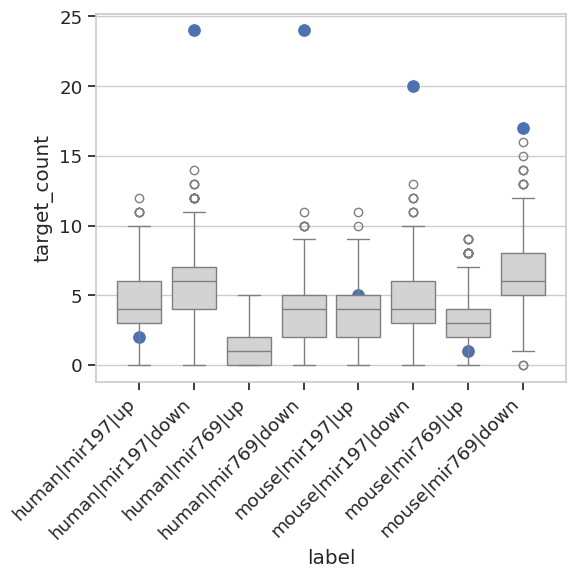

In [65]:
sns.set(rc={'figure.figsize':(6,6), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')

# sns.lineplot(background_df, x='label', y='target_count', markers=True)
fig = sns.boxplot(background_df, x='label', y='target_count', color='lightgrey')
sns.scatterplot(observed_df, x='label', y='target_count', s=100)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{outdir}/targetscan_boxplot.svg')
plt.show()

## One sided t-test if set contains more targets than expected by chance 

In [82]:
from scipy.stats import ttest_1samp, norm, zscore, mannwhitneyu
import numpy as np

def onesided_t_test(background, value):
    studres = ttest_1samp(background.values, popmean=value)
    logger.debug(studres)
    return studres.pvalue

def zscore_test(background, value, alternative='less'):
    dist = list(background.values)
    mean_bg = np.mean(dist)
    std_bg = np.std(dist, ddof=1)  # Use sample standard deviation

    z = (value - mean_bg) / std_bg
    if alternative == 'less':
        p = norm.sf(z)
    elif alternative == 'two-sided':
        p = norm.sf(abs(z)) * 2
    return p

def mannu(background, value):
    u_stat, p_value = mannwhitneyu(background.values, [value], alternative='less')
    return p_value
    

logger.setLevel(logging.INFO)
for i, row in observed_df.iterrows():
    label, target_count = row
    background = background_df['target_count'][background_df.label == label]
    # p = onesided_t_test(background, target_count)
    p = zscore_test(background, target_count, alternative='two-sided')
    # p = mannu(background, target_count)
    if p <= 0.01:
        is_significant = True
    else:
        is_significant = False

    print(f'{label} pvalue: {p}, is significant: {is_significant}')


human|mir197|up pvalue: 0.21117625949934649, is significant: False
human|mir197|down pvalue: 7.975457782309494e-15, is significant: True
human|mir769|up pvalue: 0.8636538316534653, is significant: False
human|mir769|down pvalue: 8.695461880144537e-30, is significant: True
mouse|mir197|up pvalue: 0.49635069934031517, is significant: False
mouse|mir197|down pvalue: 1.217482806492067e-13, is significant: True
mouse|mir769|up pvalue: 0.24975493761165835, is significant: False
mouse|mir769|down pvalue: 8.49206643180228e-06, is significant: True


## Alternative visualization with background as lineplot

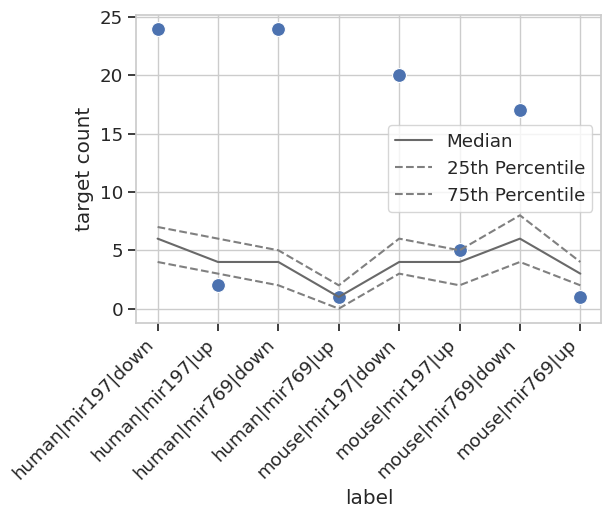

In [49]:
import numpy as np

sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')

# Group by the 'label' and calculate the percentiles
grouped_background = background_df.groupby('label')['target_count'].agg(
    median='median', 
    q25=lambda x: x.quantile(0.25), 
    q75=lambda x: x.quantile(0.75)
).reset_index()

sns.lineplot(data=grouped_background, x='label', y='median', label='Median', color='dimgrey')
sns.lineplot(data=grouped_background, x='label', y='q25', label='25th Percentile', linestyle='--', color='grey')
sns.lineplot(data=grouped_background, x='label', y='q75', label='75th Percentile', linestyle='--', color='grey')
sns.scatterplot(observed_df, x='label', y='target_count', s=100)
plt.xticks(rotation=45, ha='right')
plt.ylabel('target count')
plt.show()